# Iowa Prison Recidivism Analysis

Flatiron School Phase 3 Data Science Project
Author: Robert Harrow

## Overview

The stakeholder for this analysis is the Iowa Department of Corrections (IDC). The IDC wants to better understand factors that may lead to recidivism and to have a model that can help predict whether a person is at risk of reoffending.

## Business Understanding

The Department of Corrections uses recidivism as an indicator on whether strategies are reducing offenders relapse into criminal behavior. It wants to use analysis to pin-point whether current strategies are failing certain populations or groups at disproportionate rates so it can better study what is or isn't working.

## Data Understanding & Preparation

To study recidivism, the IDC maintains a database of prisoner recidivism. The file contains 17 features, and over 26,000 records - each pertaining to a given prisoner between 2010 and 2015.

The TARGET column was 'Return to Prison', which indicates whether the prisoner returned to prison within 3 years of release. Below is a dictionary explaining the data.

Here is how the data is distributed

| Class = 'Return to Prison' | Occurrences | % of Total |
|----------------------------|-------------|------------|
| Yes (1)                    | 8681        | 35%        |
| No (0)                     | 17339       | 65%        |

From the IDC:

"This dataset reports whether an offender is re-admitted to prison or not within three years from being released from prison in Iowa. The recidivism reporting year is the fiscal year (year ending June 30) marking the end of the three year tracking period.

The Department of Corrections uses recidivism as an indicator on whether strategies are reducing offenders relapse into criminal behavior. A three year time frame is used as studies have shown if an offender relapses into criminal behavior it is most likely to happen within three years of being released."

### Importing Dataset

Dataset located at: https://mydata.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4

**Load Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTEN
from imblearn import under_sampling, over_sampling
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

import warnings
warnings.filterwarnings('ignore')

### Data Dictionary

| Column Name                | Description                                                                                                                                                                                                          |
|:---------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fiscal Year Released       | Fiscal year (year ending June 30) for which the offender was released from prison.                                                                                                                                   |
| Recidivism Reporting Year  | Fiscal year (year ending June 30) that marks the end of the 3-year tracking period. For example, offenders exited prison in FY 2012 are found in recidivism reporting year FY 2015.                                  |
| Main Supervising District  | The Judicial District supervising the offender for the longest time during the tracking period.                                                                                                                      |
| Release Type               | Reasoning for Offender's release from prison.                                                                                                                                                                        |
| Race - Ethnicity           | Offender's Race and Ethnicity                                                                                                                                                                                        |
| Age At Release             | Offender's age group at release from prison.                                                                                                                                                                         |
| Sex                        | Gender of our offender                                                                                                                                                                                               |
| Offense Classification     | Maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days                 |
| Offense Type               | General category for the most serious offense for which the offender was placed in prison.                                                                                                                           |
| Offense Subtype            | Further classification of the most serious offense for which the offender was placed in prison.                                                                                                                      |
| Return to Prison           | No = Did not return to prison within the three year tracking period; Yes = Admitted to prison for any reason within the three year tracking period                                                                   |
| Days to Return             | Number of days it took before the offender returned to prison.                                                                                                                                                       |
| Recidivism Type            | Indicates the reason for return to prison.                                                                                                                                                                           |
| New Offense Classification | New conviction maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days  |
| New Offense Type           | General category for the new conviction while the offender is out of prison.                                                                                                                                         |
| New Offense Sub Type       | Further classification of the new conviction.                                                                                                                                                                        |
| Target Population          | The Department of Corrections has undertaken specific strategies to reduce recidivism rates for prisoners who are on parole.                                                                                         |


In [2]:
prisoner_df = pd.read_csv('data/recidivism.csv')

In [3]:
# Preview first 5 rows
prisoner_df.head()

,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Days to Return,Recidivism Type,New Offense Classification,New Offense Type,New Offense Sub Type,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.0,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.0,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.0,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.0,Tech,NaN,NaN,NaN,No


In [4]:
# Get overview of the data
prisoner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fiscal Year Released        26020 non-null  int64  
 1   Recidivism Reporting Year   26020 non-null  int64  
 2   Main Supervising District   16439 non-null  object 
 3   Release Type                24258 non-null  object 
 4   Race - Ethnicity            25990 non-null  object 
 5   Age At Release              26017 non-null  object 
 6   Sex                         26017 non-null  object 
 7   Offense Classification      26020 non-null  object 
 8   Offense Type                26020 non-null  object 
 9   Offense Subtype             26020 non-null  object 
 10  Return to Prison            26020 non-null  object 
 11  Days to Return              8681 non-null   float64
 12  Recidivism Type             26020 non-null  object 
 13  New Offense Classification  671

In [5]:
# Explore distribution of target
prisoner_df['Return to Prison'].value_counts()

No     17339
Yes     8681
Name: Return to Prison, dtype: int64

In [6]:
# Exploring proportion of missing data
prisoner_df.isna().mean()

Fiscal Year Released          0.000000
Recidivism Reporting Year     0.000000
Main Supervising District     0.368217
Release Type                  0.067717
Race - Ethnicity              0.001153
Age At Release                0.000115
Sex                           0.000115
Offense Classification        0.000000
Offense Type                  0.000000
Offense Subtype               0.000000
Return to Prison              0.000000
Days to Return                0.666372
Recidivism Type               0.000000
New Offense Classification    0.741814
New Offense Type              0.741814
New Offense Sub Type          0.742544
Target Population             0.000000
dtype: float64

### Basic Data Cleaning

Data is missing for the following columns:
* **Main Supervising District.** Based on an email I received from the Iowa Department of Corrections <em>"When a Main Supervising District is blank, this means they discharged straight from prison and were not supervised by Community Based Corrections."</em>
* **Release Type/Race - Ethnicity/Age At Release/Sex.** Just 0.01% - 6% of data is missing here. I will likely just drop these records.
* **Days to Return/New Offense Classification/New Offense Type/New Offense Sub Type.** It makes sense for this data to be missing since we have records of people who never returned to prison. Also, we don't need these columns for modeling.

In [7]:
# Replacing Main Supervising District NaN with 'None'
prisoner_df['Main Supervising District'] = prisoner_df['Main Supervising District'].fillna('None')

In [8]:
# Dealing with records with small amounts of missing values
prisoner_df.dropna(subset=['Release Type', 'Race - Ethnicity','Age At Release ','Sex'], inplace=True)

In [9]:
# Dropping columns not needed for modeling
cols_to_drop = ['Fiscal Year Released',
                'Recidivism Reporting Year',
                'Days to Return',
                'Recidivism Type',
                'New Offense Classification',
                'New Offense Type',
                'New Offense Sub Type',
#                'Offense Subtype'
               ]

In [10]:
prisoner_df_relevant = prisoner_df.drop(cols_to_drop, axis=1)

In [11]:
prisoner_df_relevant["Return to Prison"].replace({"Yes": 1, "No": 0}, inplace=True)

In [12]:
for col in prisoner_df_relevant.columns:
    print(prisoner_df_relevant[col].value_counts())

None                  7787
5JD                   4982
1JD                   2787
2JD                   1988
8JD                   1556
7JD                   1514
3JD                   1188
6JD                   1098
4JD                    666
ISC                    350
Interstate Compact     309
Name: Main Supervising District, dtype: int64
Parole                                 9810
Parole Granted                         5577
Discharged – End of Sentence           5007
Discharged - Expiration of Sentence    2335
Released to Special Sentence            401
Special Sentence                        347
Paroled w/Immediate Discharge           334
Paroled to Detainer - Out of State      137
Paroled to Detainer - INS               134
Paroled to Detainer - U.S. Marshall      77
Paroled to Detainer - Iowa               66
Name: Release Type, dtype: int64
White - Non-Hispanic                               16460
Black - Non-Hispanic                                5687
White - Hispanic          

In [13]:
# Dropping records in some groups for which we don't much data for
prisoner_df_relevant = prisoner_df_relevant.groupby('Race - Ethnicity').filter(lambda x: len(x) > 100)
prisoner_df_relevant = prisoner_df_relevant.groupby('Offense Classification').filter(lambda x: len(x) > 100)
prisoner_df_relevant = prisoner_df_relevant.groupby('Offense Subtype').filter(lambda x: len(x) > 100)

In [14]:
# Interstate Compact and ISC are the same thing, just coded differently
prisoner_df_relevant["Main Supervising District"].replace({"Interstate Compact": "ISC"}, inplace=True)

### Split data for cleaning & training

In [15]:
X = prisoner_df_relevant.drop(['Return to Prison'], axis=1)
y = prisoner_df_relevant['Return to Prison']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Creating Helper Functions to Clean Data & Score Models

Based on some emails I exchanged with a representative of the IDC, I was able to help clean up some data and group it into smaller buckets. Some labels meant the same thing, but were coded differently. This applies to "Release Type" and "Offense Classification.

In [16]:
# Cleaning up labels related to Release Type

def release_type_transformer(df):
    df.loc[df['Release Type'].str.contains('parole', case=False), 'Release Type'] = 'parole'
    df.loc[df['Release Type'].str.contains('discharged', case=False), 'Release Type'] = 'discharged'
    df.loc[df['Release Type'].str.contains('special', case=False), 'Release Type'] = 'special sentence'
    return df

# Function for cleaning up offense classifications with 'enhanced' label
def offense_classification_transformer(df):
    df.loc[df['Offense Classification'].str.contains('enhance', case=False),
           'Offense Classification'] = 'enhanced felony'
    return df

# Creating helper function that will help me understand how the models do

def model_performance(pipe, X, y):
    
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    cv = cross_validate(pipe, X, y, return_train_score=True, scoring=scoring)
    
    # Printing Train & CV Scores
    
    print('Training Accuracy', round(cv['train_accuracy'].mean(),3))
    print('---')
    print('Cross_Val Accuracy', round(cv['test_accuracy'].mean(),3))
    print('---')
    print('Training Macro Precision:', round(cv['train_precision_macro'].mean(),3))
    print('Cross_Val Macro Precision:', round(cv['test_precision_macro'].mean(),3))
    print('---')
    print('Training Macro Recall:', round(cv['train_recall_macro'].mean(),3))
    print('Cross_Val Macro Recall:', round(cv['test_recall_macro'].mean(),3))
    print('---')
    print('Training Macro F1:', round(cv['train_f1_macro'].mean(),3))
    print('Cross_Val Macro F1:', round(cv['test_f1_macro'].mean(),3))
   
    # Plotting a confusion matrix
    plot_confusion_matrix(pipe, X, y, normalize='true')

In [17]:
# I now create a pipeline for cleaning
cleaning_pipeline = Pipeline(steps=[
    ('release', FunctionTransformer(release_type_transformer)),
    ('classification', FunctionTransformer(offense_classification_transformer))
])

In [18]:
# Applying the cleaning pipeline to the training data
X_train_clean = cleaning_pipeline.fit_transform(X_train)

### Model Iterations

Next we begin modeling.

My main score will be **macro recall**. This is because I'm interested in correctly predicting a specific class (return to prison). I will, however, keep an eye on precision and accuracy since I don't want a model that just always guesses the minority class.

### Dummy classifier

I start with a dummy classifier that just guesses the majority class (in this case that's people who don't return to prison). This dummy will serve as a baseline to score our other models.

In [19]:
dummy_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('dc', DummyClassifier(strategy='most_frequent'))])

In [20]:
dummy_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ohe', OneHotEncoder(sparse=False)),
                ('dc', DummyClassifier(strategy='most_frequent'))])

Training Accuracy 0.656
---
Cross_Val Accuracy 0.656
---
Training Macro Precision: 0.328
Cross_Val Macro Precision: 0.328
---
Training Macro Recall: 0.5
Cross_Val Macro Recall: 0.5
---
Training Macro F1: 0.396
Cross_Val Macro F1: 0.396


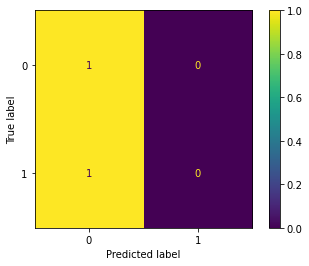

In [21]:
# Score the model
model_performance(dummy_pipe, X_train_clean, y_train)

### Decision Tree classifier

We start with a Decision Tree. Decision trees are highly interoperable which is great for our use-case since we're trying to do inferential analysis to determine factors leading to recidivism.

#### Iteration 1
We start off by running a Decision Tree with all default parameters.

In [22]:
dt_pipe = Pipeline(steps=[
    ["ohe", OneHotEncoder(sparse=False)],
    ['dt', DecisionTreeClassifier(random_state=123)]
])

dt_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ohe', OneHotEncoder(sparse=False)),
                ['dt', DecisionTreeClassifier(random_state=123)]])

Training Accuracy 0.79
---
Cross_Val Accuracy 0.631
---
Training Macro Precision: 0.793
Cross_Val Macro Precision: 0.568
---
Training Macro Recall: 0.726
Cross_Val Macro Recall: 0.555
---
Training Macro F1: 0.742
Cross_Val Macro F1: 0.553


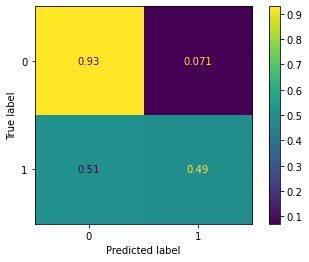

In [23]:
# Score the model
model_performance(dt_pipe, X_train_clean, y_train)

**Model Evaluation:** This is an improvement over the dummy model based on the improvement to both recall and precision, without much of a hit to accuracy. However, it looks like we're overfitting based on the disparity between training and cross_val scores.

#### Decision Tree Iteration  2 - GridSearch

Next we will GridSearch over different hyperparameters to see if we can drive better performance and also reduce overfitting.

To reduce overfitting in a Decision Tree we can try pre-prunning by altering hyperparameters like max_depth, min_samples_leaf and min_samples_split.

In [24]:
dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [3, 5, 10, 15, 20],
    'dt__min_samples_split': [2, 5, 7, 10],
    'dt__min_samples_leaf': [2, 3, 5],
    'dt__class_weight': [None, 'balanced']
}

dt_gridsearch = GridSearchCV(estimator=dt_pipe, 
                          param_grid=dt_param_grid)

# Fit the training data
dt_gridsearch.fit(X_train_clean, y_train)

# We look to see the best parameters according to the above GridSearch
print(dt_gridsearch.best_params_)

{'dt__class_weight': None, 'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10}


Training Accuracy 0.676
---
Cross_Val Accuracy 0.662
---
Training Macro Precision: 0.632
Cross_Val Macro Precision: 0.604
---
Training Macro Recall: 0.573
Cross_Val Macro Recall: 0.557
---
Training Macro F1: 0.562
Cross_Val Macro F1: 0.543


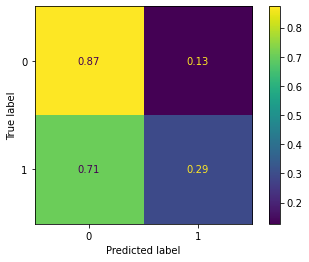

In [55]:
# Now we run this Decision Tree and score it
dt_pipe2 = Pipeline(steps=[
    ["ohe", OneHotEncoder(sparse=False)],
    ['dt', DecisionTreeClassifier(criterion='entropy',
                                  max_depth = 10,
                                  min_samples_leaf = 2,
                                  min_samples_split= 10,
                                  random_state=123)]
])

dt_pipe2.fit(X_train_clean, y_train)

model_performance(dt_pipe2, X_train_clean, y_train)

**Model Evaluation:** While overfitting was solved, our recall score dropped substantially to something just above our baseline model. It looks like this model basically mostly guessed the dominant class.

#### Decision Tree Iteration 3 - Dealing with Class Imbalance

Given the data is somewhat imbalanced (65/35 split), we next look to see whether oversampling with SMOTEN improves our decision tree.

Training Accuracy 0.618
---
Cross_Val Accuracy 0.59
---
Training Macro Precision: 0.62
Cross_Val Macro Precision: 0.593
---
Training Macro Recall: 0.633
Cross_Val Macro Recall: 0.603
---
Training Macro F1: 0.609
Cross_Val Macro F1: 0.581


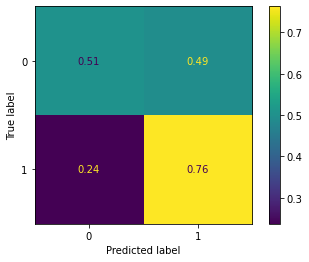

In [56]:
dt_pipe3 = imbpipe(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('sm', SMOTEN(random_state=123)),
    ('dt', DecisionTreeClassifier(criterion='entropy',
                                  max_depth = 10,
                                  min_samples_leaf = 2,
                                  min_samples_split= 10,
                                  random_state=123))
])

# Fit the training data
dt_pipe3.fit(X_train_clean, y_train)

model_performance(dt_pipe3, X_train_clean, y_train)

**Model Evaluation:** This is the best performing model so far based on recall, which is what we care about for the business case. The accuracy is still not as good as the dummy model, but that may be a cost worth paying.

### Random Forest classifier

A natural next step after trying a Decision Tree is to try a random forest. So that's what we'll do.

#### Random Forest Iteration 1 - Default Parameters

Training Accuracy 0.79
---
Cross_Val Accuracy 0.64
---
Training Macro Precision: 0.779
Cross_Val Macro Precision: 0.583
---
Training Macro Recall: 0.739
Cross_Val Macro Recall: 0.568
---
Training Macro F1: 0.751
Cross_Val Macro F1: 0.568


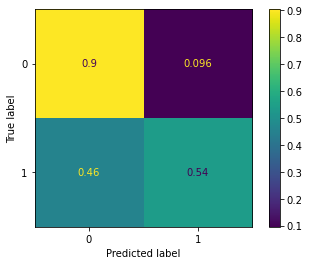

In [27]:
rf_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('rf',  RandomForestClassifier())
])

rf_pipe.fit(X_train_clean, y_train)

model_performance(rf_pipe, X_train_clean, y_train)

**Model Evaluation:** Immediately  with a random forest we run into overfitting issues. The scores are promising, but we need to see if they will hold after dealing with overfitting.

#### Random Forest Iteration 2 - GridSearch

Once again, we search over some hyperparameters here in an effort to reduce overfitting.

In [28]:
# Searching for the best RF hyperparameters

rf_grid = [{'rf__max_depth': [4, 5, 6], 
         'rf__min_samples_split': [3, 5, 10], 
         'rf__min_samples_leaf': [2, 3, 5],
         'rf__n_estimators': [2, 3, 4, 5, 200],
         'rf__class_weight': [None, 'balanced']
           }]

rf_gridsearch = GridSearchCV(estimator=rf_pipe, 
                          param_grid=rf_grid)

# Fit the training data
rf_gridsearch.fit(X_train_clean, y_train)

# Print the best params
print(rf_gridsearch.best_params_)

{'rf__class_weight': None, 'rf__max_depth': 6, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 3}


Training Accuracy 0.661
---
Cross_Val Accuracy 0.659
---
Training Macro Precision: 0.643
Cross_Val Macro Precision: 0.619
---
Training Macro Recall: 0.512
Cross_Val Macro Recall: 0.509
---
Training Macro F1: 0.429
Cross_Val Macro F1: 0.425


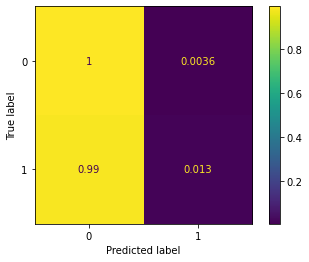

In [57]:
# Run and score a model using the above hyper-parameters

rf_pipe2 = Pipeline(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('dt',  RandomForestClassifier(max_depth = 6,
                                   min_samples_leaf = 5,
                                   min_samples_split = 3,
                                   n_estimators = 3,
                                   class_weight = None,
                                   random_state=123))
])

rf_pipe2.fit(X_train_clean, y_train)

model_performance(rf_pipe2, X_train_clean, y_train)

**Model Evaluation:** Like with decision trees, overfitting was solved by the gridsearch at the cost of Recall - which is not acceptable. For Decision Trees, dealing with Class Imbalance through SMOTEN helped so that's what we'll do next.

#### Random Forest Iteration 3 - SMOTEN

Now we try the above, correcting for class imbalance.

Training Accuracy 0.578
---
Cross_Val Accuracy 0.571
---
Training Macro Precision: 0.596
Cross_Val Macro Precision: 0.592
---
Training Macro Recall: 0.605
Cross_Val Macro Recall: 0.6
---
Training Macro F1: 0.573
Cross_Val Macro F1: 0.567


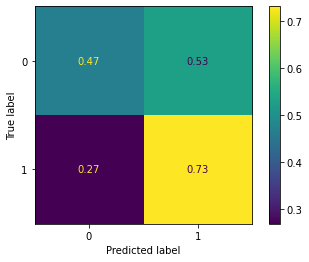

In [30]:
rf_pipe3 = imbpipe(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('sm', SMOTEN(random_state=123)),
    ('dt',  RandomForestClassifier(max_depth = 5,
                                   min_samples_leaf = 5,
                                   min_samples_split = 3,
                                   n_estimators = 3,
                                   random_state=123))
])

rf_pipe3.fit(X_train_clean, y_train)

model_performance(rf_pipe3, X_train_clean, y_train)

**Model Evaluation** The recall improved to our best performing Decision Tree model, but has worse accuracy. So we abandon Random Forests and move on to something else.

### XGBoost classifier

Next we try to improve on the model using XGBoost.

#### XGBoost Iteration 1 - Default Parameters
Like before, we start by just running the default hyperparameters.

Training Accuracy 0.727
---
Cross_Val Accuracy 0.657
---
Training Macro Precision: 0.71
Cross_Val Macro Precision: 0.597
---
Training Macro Recall: 0.644
Cross_Val Macro Recall: 0.566
---
Training Macro F1: 0.651
Cross_Val Macro F1: 0.561


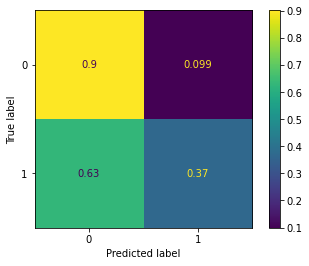

In [31]:
# Optimized XGBoost Classifier
xgb_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('xg', XGBClassifier())
])

xgb_pipe.fit(X_train_clean, y_train)

model_performance(xgb_pipe, X_train_clean, y_train)

**Model Evaluation:** Like before, we didn't get the best results with just the default hyperparameters. There is some indication of overfitting. So we move to a GridSearch.

#### XGBoost Iteration 2 - GridSearch

In [32]:
# Searching for the best hyperparameters

xgb_grid = {
    'xg__learning_rate': [0.05, 0.10, 0.15],
    'xg__max_depth': [3, 6, 12, 15],
    'xg__min_child_weight': [1, 3, 5, 7],
    'xg__subsample': [0.5, 0.7]
}

xgb_gridsearch = GridSearchCV(estimator=xgb_pipe, 
                          param_grid=xgb_grid)

# Fit the training data
xgb_gridsearch.fit(X_train_clean, y_train)

# Print the recall on test set and best params
print(xgb_gridsearch.best_params_)

{'xg__learning_rate': 0.05, 'xg__max_depth': 6, 'xg__min_child_weight': 1, 'xg__subsample': 0.5}


Training Accuracy 0.687
---
Cross_Val Accuracy 0.669
---
Training Macro Precision: 0.661
Cross_Val Macro Precision: 0.621
---
Training Macro Recall: 0.577
Cross_Val Macro Recall: 0.557
---
Training Macro F1: 0.563
Cross_Val Macro F1: 0.538


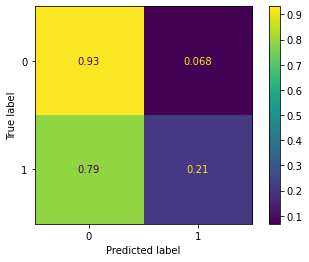

In [58]:
# Optimized XGBoost Classifier
xgb_pipe2 = Pipeline(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('xg', XGBClassifier(learning_rate = 0.05,
                         max_depth = 6,
                         min_child_weight = 1,
                         subsample = 0.5,
                         random_state=123))
])

xgb_pipe2.fit(X_train_clean, y_train)

model_performance(xgb_pipe2, X_train_clean, y_train)

**Model Evaluation:** No or minimal overfitting, but a lackluster recall score compared to the DecisionTree from before. However, we haven't dealt with ClassImbalance yet, which is where the other models so far had their best showing so I do that next.

#### XGBoost Iteration 3 - SMOTEN

Training Accuracy 0.645
---
Cross_Val Accuracy 0.615
---
Training Macro Precision: 0.636
Cross_Val Macro Precision: 0.605
---
Training Macro Recall: 0.65
Cross_Val Macro Recall: 0.616
---
Training Macro F1: 0.632
Cross_Val Macro F1: 0.601


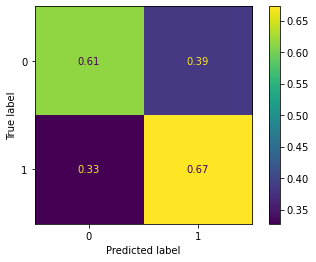

In [59]:
xgb_pipe3 = imbpipe(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('sm', SMOTEN(random_state=123)),
    ('dt',  XGBClassifier(learning_rate = 0.05,
                         max_depth = 6,
                         min_child_weight = 1,
                         subsample = 0.5,
                         random_state=123))
])

# Fit the training data
xgb_pipe3.fit(X_train_clean, y_train)

model_performance(xgb_pipe3, X_train_clean, y_train)

**Model Evaluation:** The best recall so far!

### Logistic Regression classifier

Next, I try one more classifier - Logistic Regression.

#### Logistic Regression Iteration 1 - Default

Training Accuracy 0.667
---
Cross_Val Accuracy 0.665
---
Training Macro Precision: 0.614
Cross_Val Macro Precision: 0.609
---
Training Macro Recall: 0.551
Cross_Val Macro Recall: 0.549
---
Training Macro F1: 0.528
Cross_Val Macro F1: 0.526


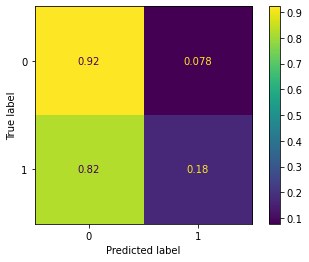

In [35]:
lr_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('lr', LogisticRegression(random_state=123))
])

lr_pipe.fit(X_train_clean, y_train)

model_performance(lr_pipe, X_train_clean, y_train)

**Model Evaluation:** Not much better than the dummy model.

#### Logistic Regression Iteration 2 - GridSearch, With Penalty

In [36]:
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 1e5], # Trying different levels of regularization
    'lr__penalty': ['l1', 'l2'], # Trying different levels of regularization
    'lr__solver': ['lbfgs', 'liblinear', 'saga'] # Trying different solvers
}

lr_gridsearch = GridSearchCV(estimator=lr_pipe, 
                          param_grid=lr_param_grid)

# Fit the training data
lr_gridsearch.fit(X_train_clean, y_train)

# Show the best parameters
print(lr_gridsearch.best_params_)

{'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


Training Accuracy 0.666
---
Cross_Val Accuracy 0.665
---
Training Macro Precision: 0.616
Cross_Val Macro Precision: 0.614
---
Training Macro Recall: 0.541
Cross_Val Macro Recall: 0.54
---
Training Macro F1: 0.506
Cross_Val Macro F1: 0.504


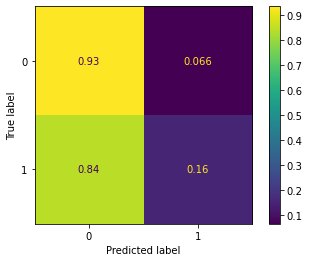

In [60]:
# Logistic Regression with best params discovered above
lr_pipe2 = Pipeline(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('lr', LogisticRegression(max_iter=1000, C = 0.1,
                              penalty = 'l1',
                              solver = 'liblinear',
                              random_state=123))
])

lr_pipe2.fit(X_train_clean, y_train)

model_performance(lr_pipe2, X_train_clean, y_train)

#### Logistic Regression Iteration 3 - SMOTEN

Next, I take that model and resolve the class imbalance.

Training Accuracy 0.623
---
Cross_Val Accuracy 0.621
---
Training Macro Precision: 0.606
Cross_Val Macro Precision: 0.604
---
Training Macro Recall: 0.615
Cross_Val Macro Recall: 0.613
---
Training Macro F1: 0.604
Cross_Val Macro F1: 0.602


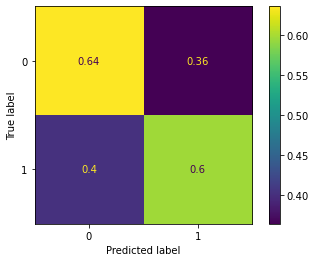

In [61]:
# Logistic Regression, No Penalty, Best Solver
lr_pipe3 = imbpipe(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('sm', SMOTEN(random_state=123)),
    ('lr', LogisticRegression(max_iter=1000, C = 0.1,
                              penalty = 'l1',
                              solver = 'liblinear',
                              random_state=123))
])

lr_pipe3.fit(X_train_clean, y_train)

model_performance(lr_pipe3, X_train_clean, y_train)

#### Logistic Regression Iteration 4 - SMOTEN, No Penalty

Training Accuracy 0.633
---
Cross_Val Accuracy 0.628
---
Training Macro Precision: 0.604
Cross_Val Macro Precision: 0.599
---
Training Macro Recall: 0.61
Cross_Val Macro Recall: 0.605
---
Training Macro F1: 0.605
Cross_Val Macro F1: 0.601


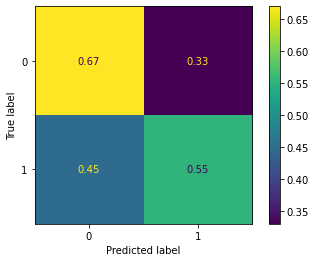

In [39]:
# Logistic Regression, No Penalty, Best Solver
lr_pipe4 = imbpipe(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('sm', SMOTEN(random_state=123)),
    ('lr', LogisticRegression(penalty = 'none', random_state=123))
])

lr_pipe4.fit(X_train_clean, y_train)

model_performance(lr_pipe4, X_train_clean, y_train)

#### Logistic Regression Iteration 5 - Class_Weight Balanced, No Penalty

Lastly, for good measure, I look to see whether setting a class balance instead of SMOTEN leads to better performance.

Training Accuracy 0.607
---
Cross_Val Accuracy 0.603
---
Training Macro Precision: 0.612
Cross_Val Macro Precision: 0.609
---
Training Macro Recall: 0.624
Cross_Val Macro Recall: 0.62
---
Training Macro F1: 0.599
Cross_Val Macro F1: 0.595


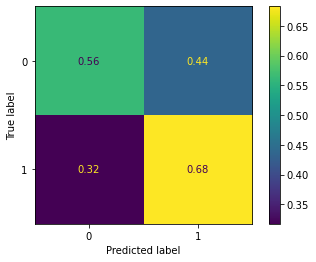

In [40]:
# Logistic Regression, No Penalty, Best Solver

lr_pipe5 = imbpipe(steps=[
    ("ohe", OneHotEncoder(sparse=False)),
    ('lr', LogisticRegression(penalty = 'none',
                              class_weight = 'balanced',
                              random_state=123))
])

lr_pipe5.fit(X_train_clean, y_train)

model_performance(lr_pipe5, X_train_clean, y_train)

**Model Evaluation:** This is the best recall score we got, so we'll move forward with this as our model.

### Model Evaluation

In [41]:
# Clean test data
X_test_clean = cleaning_pipeline.transform(X_test)

# Use model to predict target
y_pred = lr_pipe5.predict(X_test_clean)

# Score model on test data
lr_pipe5.score(X_test_clean, y_test)

print('Recall score: ', round(recall_score(y_test, y_pred, average='macro'), 3))
print('Precision score: ', round(precision_score(y_test, y_pred, average='macro'), 3))
print('F1 score: ', round(f1_score(y_test, y_pred, average='macro'), 3))

Recall score:  0.633
Precision score:  0.62
F1 score:  0.606


### Investigating the Best Performing Model
Out of all the different models and hyper-parameters we tried above, we got the best performance using Logistic Regression. Let's take a look at the coefficients driving that model.

In [62]:
coefs = list(lr_pipe5['lr'].coef_[0])
features = list(lr_pipe5['ohe'].get_feature_names())
zipped = list(zip(features,coefs))
results = pd.DataFrame(zipped, columns=['Feature','Coefficient'])

In [63]:
results.sort_values(by='Coefficient', ascending=False)

,Feature,Coeffficient
13,x2_American Indian or Alaska Native - Non-Hisp...,0.535666
4,x0_5JD,0.518542
44,x7_Other Criminal,0.446636
3,x0_4JD,0.436635
1,x0_2JD,0.380464
12,x1_special sentence,0.370741
36,x7_Alcohol,0.359166
22,x3_Under 25,0.343919
0,x0_1JD,0.324822
41,x7_Forgery/Fraud,0.306303


Looking at the coefficients above, it seems that the following features have a relatively higher predictive power as to whether an individual is likely to return to prison within 3 years of release:

* Supervising District
* Race - Ethnicity
* Offense Subtype
* Release Type

In the next section we take a closer look at these features and create some visualizations to help better see their effect on the target outcome.

## Exploratory Data Analysis

First, we take our cleaned training data and put it back together for the purposes of EDA.

In [44]:
# Create the cleaned dataset
clean_data = pd.concat([y_train, X_train_clean], axis=1)

In [45]:
# Double check the columns
clean_data.columns

Index(['Return to Prison', 'Main Supervising District', 'Release Type',
       'Race - Ethnicity', 'Age At Release ', 'Sex', 'Offense Classification',
       'Offense Type', 'Offense Subtype', 'Target Population'],
      dtype='object')

In [46]:
# Get average occurrence of recidivism across all data as a benchmark
avg_recidivism = clean_data['Return to Prison'].value_counts(normalize=True)[1]

#### Looking at Recidivism by Supervising District

Persons released from prison are either released to one of 8 Supervising Districts, discharged completely or discharged out-of-state (to ISC).

**NOTE:** While rates look low for persons released to ISC (Interstate Compact) that is potentially misleading. These persons leave Iowa state, and if they return to a prison not located in Iowa, the IDC does not receive data on that.

In [47]:
# Create a crosstab of our data for the feature
recidvism_by_district = pd.crosstab(clean_data['Main Supervising District'],
                                    clean_data['Return to Prison'],
                                    normalize='index')

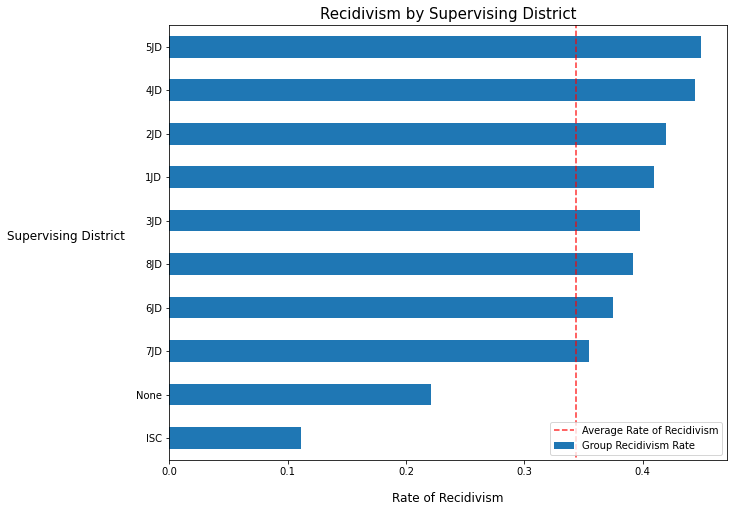

In [48]:
# Graph the results
fig, ax = plt.subplots(figsize=(10, 8))
recidvism_by_district[1].sort_values().plot.barh(ax=ax)
plt.title('Recidivism by Supervising District', size=15)
plt.xlabel('Rate of Recidivism',  rotation=0, size=12, labelpad=15)
plt.ylabel('Supervising District',  rotation=0, size=12, labelpad=70)

# Adding line to emphasize average recidivism rate in population
plt.vlines(x=avg_recidivism, ymin=-50, ymax=100, alpha=0.8, color='red', ls='--')

plt.legend()
ax.legend(labels=['Average Rate of Recidivism', 'Group Recidivism Rate'])
plt.show()

#### Looking at Recidivism by Race - Ethnicity

Another strong predictor in the model was whether the person was a Non-Hispanic American Indian or Alaska Native. The IDC should investigate why its current strategies are failing to help this group.

The results for this and other races and ethnicities are shown below.

In [49]:
recidvism_by_race = pd.crosstab(clean_data['Race - Ethnicity'],
                               clean_data['Return to Prison'],
                               normalize='index')

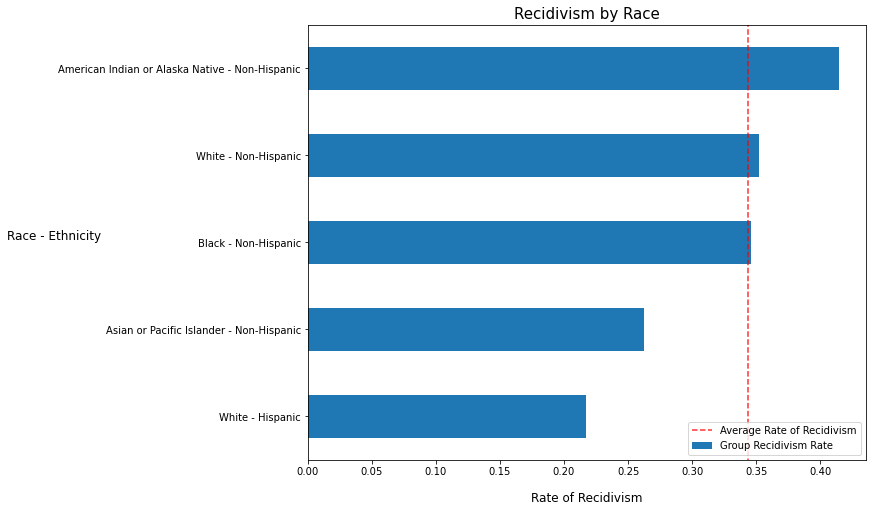

In [69]:
# Graph the crosstab table
fig, ax = plt.subplots(figsize=(10, 8))
recidvism_by_race[1].sort_values().plot.barh(ax=ax)
plt.title('Recidivism by Race', size=15)
plt.xlabel('Rate of Recidivism', size=12, rotation=0, labelpad=15)
plt.ylabel('Race - Ethnicity', rotation = 0, size=12)

# Adding line to emphasize average recidivism rate in population
plt.vlines(x=avg_recidivism, ymin=-50, ymax=100, alpha=0.8, color='red', ls='--')

plt.legend()
ax.legend(labels=['Average Rate of Recidivism', 'Group Recidivism Rate'])
plt.show()

#### Looking at Recidivism by Offense Subtype

Persons in prison for certain offense subtypes showed a greater likelihood of having above-average recidivism rates.

* Persons with the 'Other Criminal' classification had the highest rate, and were the third strongest predictor in our model
* This was followed by those who committed Burglary and Alcohol-related crimes.

In [64]:
recidvism_by_off_subtype = pd.crosstab(clean_data['Offense Subtype'],
                               clean_data['Return to Prison'],
                               normalize='index')

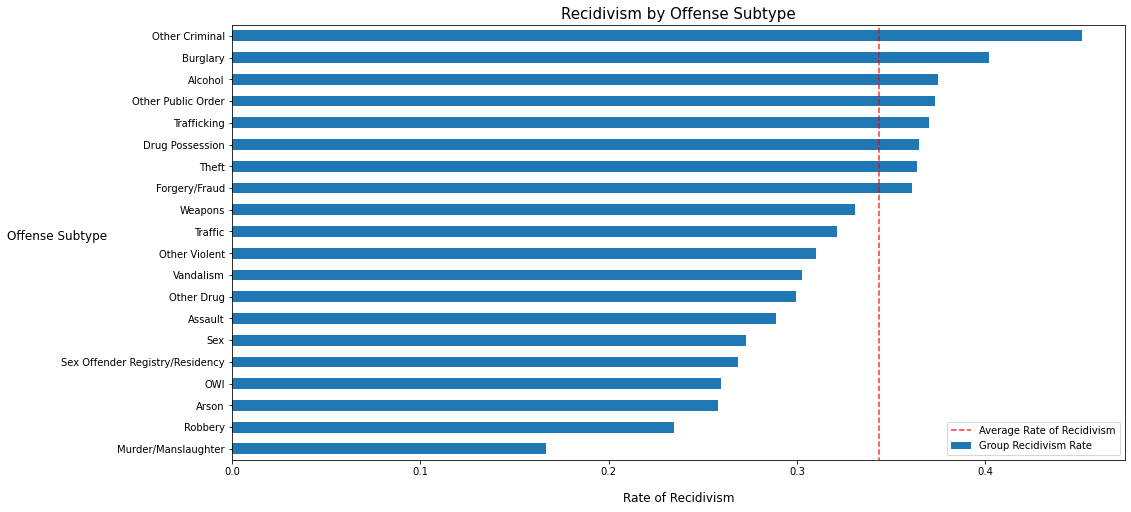

In [68]:
# Graph the crosstab table
fig, ax = plt.subplots(figsize=(16, 8))
recidvism_by_off_subtype[1].sort_values().plot.barh(ax=ax)
plt.title('Recidivism by Offense Subtype', size=15)
plt.ylabel('Offense Subtype', rotation = 0, size=12)
plt.xlabel('Rate of Recidivism', size=12, rotation=0, labelpad=15)

# Adding line to emphasize average recidivism rate in population
plt.vlines(x=avg_recidivism, ymin=-50, ymax=100, alpha=0.8, color='red', ls='--')

plt.legend()
ax.legend(labels=['Average Rate of Recidivism', 'Group Recidivism Rate'])
plt.xticks(rotation = 0)
plt.show()

#### Looking at Recidivism by Type of Release

Finally, the type of release was the 4th strongest predictor. Individuals released on a special sentence had significantly higher rates of recidivism compared to those discharged without special conditions and those discharged on parole.

Special Sentences apply to Class "B" and Class "C" felonies and a definition can be found [here](https://www.legis.iowa.gov/docs/code/903B.1.pdf).

In [53]:
recidvism_by_release = pd.crosstab(clean_data['Release Type'],
                               clean_data['Return to Prison'],
                               normalize='index')

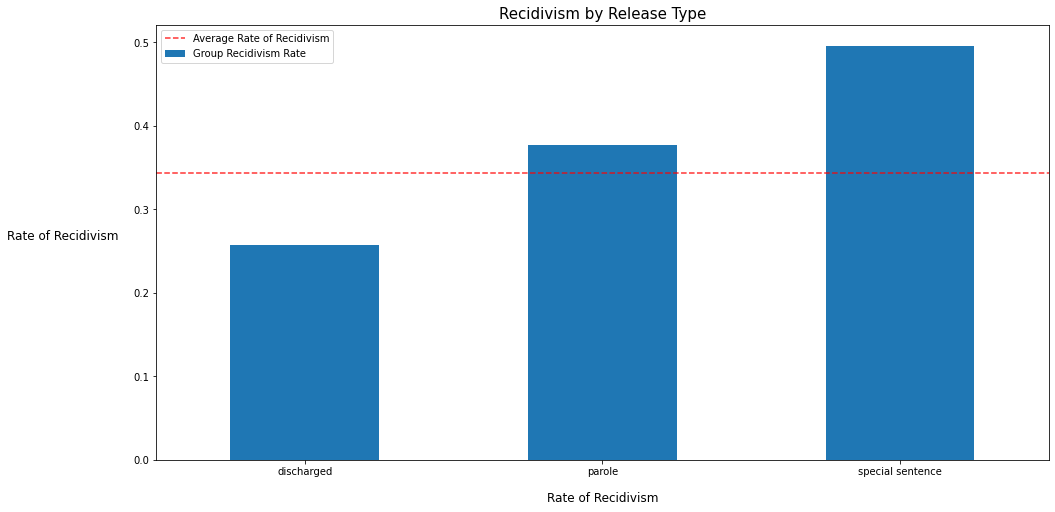

In [54]:
# Graph the results
fig, ax = plt.subplots(figsize=(16, 8))
recidvism_by_release[1].sort_values().plot.bar(ax=ax)
plt.title('Recidivism by Release Type', size=15)
plt.ylabel('Rate of Recidivism', size=12, rotation=0, labelpad=70)
plt.xlabel('Rate of Recidivism',  rotation=0, size=12, labelpad=15)

# Adding line to emphasize average recidivism rate in population
plt.hlines(y=avg_recidivism, xmin=-50, xmax=100, alpha=0.8, color='red', ls='--')

plt.legend()
ax.legend(labels=['Average Rate of Recidivism', 'Group Recidivism Rate'])
plt.xticks(rotation = 0)
plt.show()

## Conclusions & Next Steps

* Our logistic regression model was able to predict recidivism with a recall score of 0.62
* The model identified that a person's Supervising District, Race - Ethnicity, Offense Subtype, and Type of Release were the most predictive features for whether or not they are likely to return to prison
  * **Supervising Districts.** Persons released to Judicial Supervising districts showed higher rates of recidivism than those released without supervision.
  * **Race - Ethnicity.** Non-Hispanic American Indian, Alaska Natives and White persons showed higher rates of recidivism relative to other races/thnicities.
  * **Offense Subtype.** Persons committing "other criminal" crimes had a higher than average likelihood of reoffending.
  * **Release Type.** Individuals released on a special sentence had far higher average recidivism rates than those released on parole or those discharged without parole.
* The Iowa Department of Corrections should investigate why its programs are disproportionately not effective in helping these persons.